# Тестовое задание для IDChess

Первым делом импортируем необходимые библиотеки.

Для решения задачи использовались:
1. numpy - библиотека для работы с матрицами и вычислениями
2. cv2 - библиотека OpenCV. Использовалась для операций с картинками
3. pandas - библиотека для удобной работы с таблицами данных (на всякий случай)
4. matplotlib - для работы с графиками и удобного вывода картинок
5. tensorflow и keras - библиотеки для Deep learning и Machine learning

In [1]:
import numpy as np
import cv2 as cv
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models

from keras import backend
from keras import metrics

print(tf.__version__)

1.13.0-rc1


Using TensorFlow backend.


считываем исходные данные

In [2]:
X_train = np.load('xtrain.npy')
y_train = np.load('ytrain.npy')
X_test = np.load('xtest.npy')

Посмотрим на их объем и форму

In [3]:
X_train.shape

(15137, 256, 256, 1)

In [4]:
y_train.shape

(15137, 8)

In [5]:
X_test.shape

(5, 256, 256, 1)

Картинки имеют кодировку только по одному каналу GRAYSCALE, поэтому для отоброжения одного примера из тренировочной выборки используем функцию перекодировки цвета в формат RGB для отображения картинки

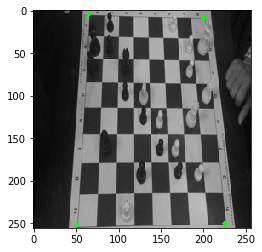

In [6]:
image_to_show = cv.cvtColor(X_train[0].astype(np.uint8), cv.COLOR_GRAY2BGR)

point_1 = (int(y_train[0][0] * 255), int(y_train[0][1] * 255))
point_2 = (int(y_train[0][2] * 255), int(y_train[0][3] * 255))
point_3 = (int(y_train[0][4] * 255), int(y_train[0][5] * 255))
point_4 = (int(y_train[0][6] * 255), int(y_train[0][7] * 255))

cv.circle(image_to_show, point_1, 1, (0,255,0), 3)
cv.circle(image_to_show, point_2, 1, (0,255,0), 3)
cv.circle(image_to_show, point_3, 1, (0,255,0), 3)
cv.circle(image_to_show, point_4, 1, (0,255,0), 3)

plt.imshow(image_to_show)
plt.show()

Нормализуем данные от 0 до 1, так как это необходимо для обучения нейронной сети, которую мы затем будем использовать

In [7]:
X_train = X_train / 255

Строим архитектуру сверточной нейронной сети. Архитектура выбрана изходя из применения в похожем примере с регрессиией для картинок в формате GRAYSCALE. На выходном слое ставим восемь точек, которые и будут искомыми значениями

In [10]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8))

Компилируем и обучаем модель. Дополнительно в модель передана метрика R2, которая более наглядно покажет процент дисперсии ответов, которую модель описывает при обучении. Минимизация строится на основе среднеквадротичной ошибки.

Следующую ячейку можно пропустить, так как обучение модели занимает достаточно много времени, и запустить следующую после нее, которая подгрузит уже обученную сохраненную в формате .h5 модель.

In [14]:
'''
def rmse(y_true, y_pred):
    return 1 - backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

model.compile(optimizer='adam',
              loss='mse',
              metrics=[rmse])

history = model.fit(X_train, y_train, epochs=1)
'''

15137/15137 [==============================] - 1589s 105ms/sample - loss: 0.0053 - rmse: 0.9696


In [ ]:
model = keras.models.load_model('idchess.h5')

Выведем параметры модели

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 230400)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                14745664  
__________

Выведем историю обучения в формате DataFrame

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,rmse,epoch
0,0.005283,0.969632,0


Необходимо нормализовать тестовые данные перед передачей их в функцию predict

In [17]:
y = model.predict(X_test / 255)

Обозначим функцию для разметки предсказанных точек на картинке и последующей печати этой картинки вместе с точками

In [18]:
def show_test_image(img, points):
    image_to_show = cv.cvtColor(img.astype(np.uint8), cv.COLOR_GRAY2BGR)
    
    if points[3] > 1: points[3] = 1
    if points[5] > 1: points[5] = 1
    
    point_1 = (int(points[0] * 255), int(points[1] * 255))
    point_2 = (int(points[2] * 255), int(points[3] * 255))
    point_3 = (int(points[4] * 255), int(points[5] * 255))
    point_4 = (int(points[6] * 255), int(points[7] * 255))
    
    cv.circle(image_to_show, point_1, 1, (0,255,0), 3)
    cv.circle(image_to_show, point_2, 1, (0,255,0), 3)
    cv.circle(image_to_show, point_3, 1, (0,255,0), 3)
    cv.circle(image_to_show, point_4, 1, (0,255,0), 3)
    
    plt.imshow(image_to_show)
    plt.show()

Результат предсказания модели

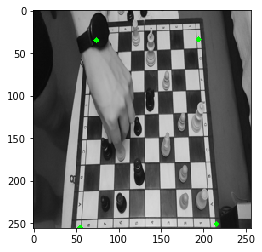

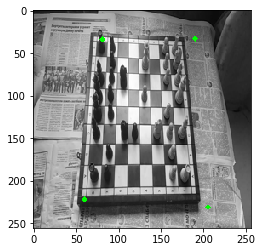

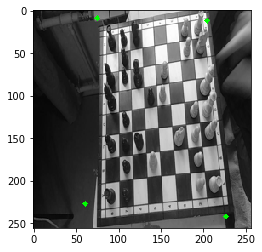

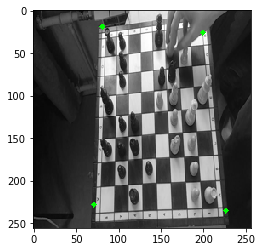

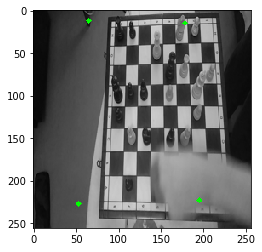

In [19]:
for i in range(len(X_test)):
    show_test_image(X_test[i], y[i])